# TABLE OF CONTENT: 

 # <a href='#A'>  Preface:</a>

# <a href='#1'>1. Text Extraction:</a>

## <a href='#1.1'> 1.1. Question (1): </a>

## <a href='#1.2'> 1.2. Solution: Uncompress the compressed file </a>

# <a href='# 2'> 2. Understanding the data:</a>

## <a href='# 2.1'>2.1. Understand the problem statetement: </a>

## <a href='# 2.2'>2.2. Basic EDA and Visualization pre-cleaning process:</a>

# <a href='# 3'>3. Text Preprocessing: </a>

## <a href='# 3.1'>3.1. Removing Noise:</a>

## <a href='# 3.2'>3.2. Removing Punctuation:</a>

## <a href='# 3.3'>3.3. Tokenization:</a>

## <a href='# 3.4'>3.4. Removing Stopwords:</a>

# <a href='# 4'> 4. Embedded Representation:</a>

## <a href='# 4.1'>4.1. Question (2.1):</a>

## <a href='# 4.2'>4.2. Solution: Embedding Visualization </a>

## <a href='# 4.3'>4.3. Question (2.2):</a>

## <a href='# 4.4'>4.4. Solution: Query similarity with gensim </a>

# <a href='# 5'>5. Text Classification: </a>

## <a href='# 5.1'>5.1. Question (2.3):</a>

## <a href='# 5.2'>5.2. Solution: Text Classification with Naive Bayes (NB) </a>

## <a href='# 5.3'>5.3. Question (2.4):</a>

## <a href='# 5.4'>5.4. Solution: Improve the accuracy of the model</a>

# <a href='# 6'>6. Extraction of Characteristic words:</a>

## <a href='# 6.1'> 6.1. Question(3):</a>

## <a href='# 6.2'>6.2. Solution: Topic Modelling with LDA</a>

# <a href='# 7'>7. Conclusion:</a>


In [1]:
# install library: 
!pip install nlplot

!pip install --upgrade pip
!pip install mecab-python3
!pip install unidic-lite

!pip install gensim
!pip install pyLDAvis

In [2]:
# Import Library: 

import warnings
warnings.filterwarnings("ignore")

import configparser
import glob
import os
import pandas as pd
import subprocess
import sys
import tarfile 
from urllib.request import urlretrieve

import nlplot

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from sklearn.manifold import TSNE

from collections import defaultdict
from gensim import corpora, models

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import re
import string

import MeCab

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import plot_confusion_matrix


from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

from gensim import corpora, models
import gensim
from pprint import pprint
from gensim.models import word2vec

import pyLDAvis
import pyLDAvis.gensim_models

#  <a id='A'>Preface: </a>

The content of this report is built on the answers for the questions of the assignment.  Please refer to the table of content to walk throught to my presentation: 

I also summary here the  insights of the assigment: 

 - Japanese text needs an extensive preprocessing step suchs as removing noise, removing punctuation, tokenization, and stopwords; (section 3)
 
 - There are several approaches to visualized the word embedding in 2D plane. In this notebook, I applied T-distributed Stochastic Neighbor Embedding (T-SNE) is a tool for visualizing high-dimensional data. In addition, I also used TSNEVisualizer - an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default) to substitute for the T-SNE method. Both plots are present in this kernel. (section 4.2)
 
 - To tackle the Query Similarity, I chose to use  the similarity with word embedding using gensim.similarities for an efficient out-of-core sharded index. Because of its is flexible class, this approach is my first choice. (section 4.4)
 
 - For text classification, I original choose Multinomial Navie Bayes. The result turns out with accuracy rate is 89.31%. To improve the accuracy of the model, different n-grams, different NB models,change BOW method, and Different non-bayesian algorithms are performed. As a result, Linear Support Vector Classifier is the model having the best accuracy rate. (section 5)
 
 - To extract the characteristic words, I used Top modeling with LDA library. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.
 
 !Caution: This notebook takes around 20 mins to run the whole kernel. I also attach html file so it can be less time consuming to investigate. 


# <a id='1'> 1.  Text Extraction: </a>

## <a id='1.1'> 1.1. Question (1):</a>

livedoor ニュースコーパスの圧縮ファイルを解凍し、展開されたディレクトリを解析し、Pandas データフ レームを生成する処理を実装してください。


Uncompress the compressed file of the livedoor news corpus, parse the expanded directory, and Pandas dataframe


## <a id='1.2'> 1.2. Solution:</a>

In [3]:
FILEURL = "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"
FILEPATH = "/home/studio-lab-user/ldcc-20140209.tar.gz" 
EXTRACTDIR = "/home/studio-lab-user/livedoor"
!mkdir -p {EXTRACTDIR} 

In [4]:
urlretrieve(FILEURL, FILEPATH)

('/home/studio-lab-user/ldcc-20140209.tar.gz',
 <http.client.HTTPMessage at 0x7f85e40b6be0>)

In [5]:
mode = "r:gz"
tar = tarfile.open(FILEPATH, mode) 
tar.extractall(EXTRACTDIR) 
tar.close()

In [6]:
# extract the categories feature:
categories = []

for name in os.listdir(os.path.join(EXTRACTDIR, "text")):
    if os.path.isdir( os.path.join(EXTRACTDIR, "text", name)):
        categories.append(name)
categories= sorted(categories)
print(categories)

['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


In [7]:
def extract_txt(filename):
    with open(filename) as text_file:

        text = text_file.readlines()[2:]
        text = [sentence.strip() for sentence in text]
        text = list(filter(lambda line: line != '', text))
        return ''.join(text)
    
table = str.maketrans({
    '\n': '',
})
table

{10: ''}

In [8]:
# get all the articles: 

all_text = []
all_label= []

num=0

for cat in categories:
    files = glob.glob(os.path.join(EXTRACTDIR, "text", cat, "{}*.txt".format(cat)))
    files = sorted(files)
    body = []
    for elem in files:
        body.append(extract_txt(elem).translate(table))
    label = [cat] * len(body)
    num_label= [num] * len(body)
    num= num + 1
    all_text.extend(body)
    all_label.extend(label)
    

# count all the articles in the document

print(len(all_text))



7367


In [10]:
# Create dataframe for all the text: 

df = pd.DataFrame({'text' : all_text, 'label' : all_label})\
    .sample(frac=1, random_state=23).reset_index(drop=True)
df.head(5)

text           label
0  新記録でロンドンに乗り込む“バタフライの女王”加藤ゆか3日に行われた競泳の日本選手権で、女子...    sports-watch
1  家電チャンネルの記事も配信！向かうところ敵なしのスマホアプリ「ITニュース by lived...   kaden-channel
2  彼にあげたい韓国メンズコスメ、韓流俳優のような美肌男へ！年末の大イベント、クリスマスまであと...          peachy
3  快適なスマホライフのための必須アプリ「マトリックス レボリューションズ」(c)Warner ...  livedoor-homme
4  独女と上司の気になる関係人事異動の多い春は、職場の人間関係の悩みも増える時期。『an・an』...  dokujo-tsushin

In [11]:
# save csv text file: 
#df.to_csv(index=False)

# <a id='2'> 2. Undestand the data:</a>

# <a id='2.1'> 2.1. Unsderstand the problem statement: </a>



The first step in any machine learning project is understanding the problem. So that’s what I’ll aim to do here.

In [12]:
print('shape of the data frame is:', df.shape)
print('number of categories are:',len(df.label.unique()))
print('categories of the entries are:',df.label.unique())


shape of the data frame is: (7367, 2)
number of categories are: 9
categories of the entries are: ['sports-watch' 'kaden-channel' 'peachy' 'livedoor-homme' 'dokujo-tsushin'
 'it-life-hack' 'movie-enter' 'smax' 'topic-news']


The dataset has 7367 rows, each containing review text from users in the internet. Each text is classified into 9 different categories: sports watch, kaden channel, peachy, livedoor hoome, dokujo tsushin, it life hack, movie enter, smax and topic news. 

* My objective is to use this data, explore it, and generate insights from it.

* The biggest challenge of the task is the text is conducted in Japanese. By it nature, Japanese is very complicated. It is composed byひらがな、カタカナ、漢字 and English (sometime). Moreover, Japanese has no space in its text,  so there’s an extra pre-processing step required before I can start using these text analysis approaches.

* Let’s get the ball rolling and explore this dataset using different techniques and generate insights from it.


## <a id='2.2'> 2.2. Basic EDA and Visualization pre-cleaning process:</a>

Text(0, 0.5, 'samples')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


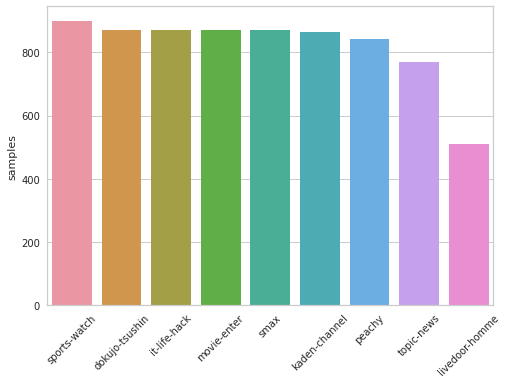

In [13]:
x=df.label.value_counts()
sns.barplot(x.index,x)
plt.xticks(rotation=45)
plt.gca().set_ylabel('samples')

The distribution of each classification is quite equal. So we could say our data is relatively balance.

In this section I will visualise our text data before cleaning it using nlplot.  nlplot is a Python library typically used in Analytics, Data Visualization, D3 application for Natural Language Processing. nlplot supports Japanese text data.

In [14]:
# target_col as a list type or a string separated by a space.
npt = nlplot.NLPlot(df, target_col='text')

# Stopword calculations can be performed.
stopwords = npt.get_stopword(top_n=10, min_freq=0)


In [15]:
# Histogram of the word count
npt.word_distribution(title='words distribution')


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



* The histogram above is heavy right-skewed. The text-length run from 2-3 words to over 300 words. 

* This result looks suspicious. The text-lenghth should run in the wider range. Potential problem is Japanese has no space in its text. Because of that, the algorithm counts a chunk of words as only one word. 

* We definetly needs to pay enough attendtion to clean the data in the next step!

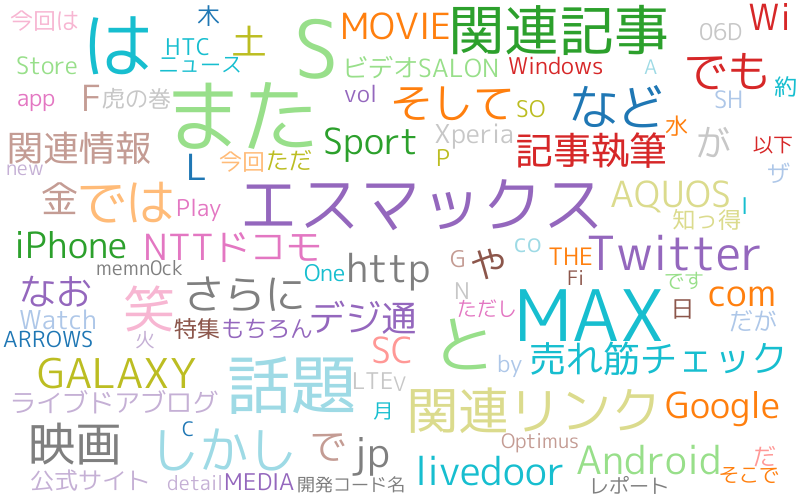

In [16]:
# wordcloud
npt.wordcloud(stopwords=stopwords, colormap='tab20_r')

Since there are so many dirt in the clouldword, I coudn't generalize any insights from this plot. 

Again, cleaning the data is a must!

In [17]:
# N-gram tree Map
npt.treemap(title='Tree of Most Common Words', ngram=1, top_n=10, stopwords=stopwords)


100%|██████████| 7367/7367 [00:00<00:00, 31061.52it/s]
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



We could say iphone smax is the most discussed topic in the internet.

In [18]:
# . co-occurrence networks
npt.build_graph(stopwords=stopwords, min_edge_frequency=10)
# The number of nodes and edges to which this output is plotted.
# If this number is too large, plotting will take a long time, so adjust the [min_edge_frequency] well.
npt.co_network(title='Co-occurrence network')

node_size:292, edge_size:2155


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



The network is too busy to interpert and bring any insights!

In [19]:
# sunburst chart
npt.sunburst(title='sunburst chart', colorscale=True)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [20]:
# . N-gram bar chart
npt.bar_ngram(title='uni-gram', ngram=1, top_n=10, stopwords=stopwords)



100%|██████████| 7367/7367 [00:00<00:00, 47578.95it/s]
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [21]:
npt.bar_ngram(title='uni-gram', ngram=1, top_n=10, stopwords=stopwords)

100%|██████████| 7367/7367 [00:00<00:00, 42657.86it/s]
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



The basic EDA and visualize above shows our data contains a lot of noise. 

We will need lot of cleaning here. Now let's get our hand dirty for the cleaning process. 

# <a id='3'>3. Text Preprocessing: </a>

Before we start modelling with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. 

Some of the basic text pre-processing techniques includes:

* Make text all lower case or uppercase so that the algorithm does not treat the same words in different cases as different

* Removing Noise: i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)

* Tokenization: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.

* Stopword Removal: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words


## <a id='3.1'>3.1. Removing Noise: </a>

In [22]:
df['text']=df['text'].astype(str) # convert series to string
df['label']=df['label'].astype(str) #convert series to string

def cleaning(text):  
    
    " converting to lowercase, removing URL links, special characters, punctuations..." 
    text = text.lower() # converting to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text) # removing URL links
    text = re.sub(r"\b\d+\b", "", text) # removing number 
    text = re.sub(r"\d+",'',text) # remove words and digits containing digits
    text = re.sub('<.*?>+', '', text) # removing special characters, 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)    
    
    return text

<>:8: DeprecationWarning:

invalid escape sequence \S

<>:8: DeprecationWarning:

invalid escape sequence \S

/tmp/ipykernel_1468/2182364436.py:8: DeprecationWarning:

invalid escape sequence \S



In [23]:
df['clean_one'] = df['text'].apply(cleaning)
df.iloc[134:136]

text           label  \
134  夏だ！海だ！プールだ！この夏の泳ぎ計画を立てよう！「全国海水浴場・プールスポット情報検索　泳...            smax   
135  新Cセグメントハッチバック「ジュリエッタ」を日本初公開フィアット グループ オートモービルズ...  livedoor-homme   

                                             clean_one  
134  夏だ！海だ！プールだ！この夏の泳ぎ計画を立てよう！「全国海水浴場・プールスポット情報検索　泳...  
135  新cセグメントハッチバック「ジュリエッタ」を日本初公開フィアット グループ オートモービルズ...

## <a id='3.2'>3.2 Remove Punctuation: </a>
At this step, I will apply an exhausive puncatioan removal. I realize in japanese text, there are some symbols such as 【】『』【】〔〕〖〗〘〙〚〛appear alot. 
An addition step to remove these special symbols is neccesary!

In [24]:
punctuations = """!()（）「」、-!！[]{};:+'"\,<>./?@#$%^&*_~Â。…・，【】？『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."""

def remove_punctuation(text):
    return text.translate(str.maketrans(' ', ' ', punctuations))

df['clean_two']= df['clean_one'].apply(lambda text: remove_punctuation(text))
df.iloc[134:136]

<>:1: DeprecationWarning:

invalid escape sequence \,

<>:1: DeprecationWarning:

invalid escape sequence \,

/tmp/ipykernel_1468/875148435.py:1: DeprecationWarning:

invalid escape sequence \,



text           label  \
134  夏だ！海だ！プールだ！この夏の泳ぎ計画を立てよう！「全国海水浴場・プールスポット情報検索　泳...            smax   
135  新Cセグメントハッチバック「ジュリエッタ」を日本初公開フィアット グループ オートモービルズ...  livedoor-homme   

                                             clean_one  \
134  夏だ！海だ！プールだ！この夏の泳ぎ計画を立てよう！「全国海水浴場・プールスポット情報検索　泳...   
135  新cセグメントハッチバック「ジュリエッタ」を日本初公開フィアット グループ オートモービルズ...   

                                             clean_two  
134  夏だ海だプールだこの夏の泳ぎ計画を立てよう全国海水浴場プールスポット情報検索　泳スポandr...  
135  新cセグメントハッチバックジュリエッタを日本初公開フィアット グループ オートモービルズ ジ...

## <a id='3.3'>3.3 Tokenization:</a>

* One of the challenge when clean the japanese text data as I mention before is there are no space between words in Japanese. We can not detele any stopwords with the current setting. Therefore, I'll use the tokenization function to split the words and then apply stopword function to delete the extreme common words.

* Japanese is written without spaces, tokenization is non-trivial, and while high quality open source tokenizers exist they can be hard to use andlack English documentation. In this section, I'll apply Mecab library - a morphological analyzer for Japanese text.

In [25]:

class MecabTokenizer:
    " develop morphological analyze function"
    def __init__(self):
        self.wakati = MeCab.Tagger("-Owakati")
        self.wakati.parse('')

    def tokenize(self, line):
        txt = self.wakati.parse(line)
        txt = txt.split()
        return txt
    
    def mecab_tokenizer(self, line):
        node = self.wakati.parseToNode(line)
        keywords = []
        while node:
            if node.feature.split(",")[0] == "名詞":
                keywords.append(node.surface)
            node = node.next
            
        return keywords       
    

In [26]:
token = MecabTokenizer()

df['clean_three'] = df['clean_two'].apply(lambda x: token.mecab_tokenizer(x))
df.iloc[134:136]

text           label  \
134  夏だ！海だ！プールだ！この夏の泳ぎ計画を立てよう！「全国海水浴場・プールスポット情報検索　泳...            smax   
135  新Cセグメントハッチバック「ジュリエッタ」を日本初公開フィアット グループ オートモービルズ...  livedoor-homme   

                                             clean_one  \
134  夏だ！海だ！プールだ！この夏の泳ぎ計画を立てよう！「全国海水浴場・プールスポット情報検索　泳...   
135  新cセグメントハッチバック「ジュリエッタ」を日本初公開フィアット グループ オートモービルズ...   

                                             clean_two  \
134  夏だ海だプールだこの夏の泳ぎ計画を立てよう全国海水浴場プールスポット情報検索　泳スポandr...   
135  新cセグメントハッチバックジュリエッタを日本初公開フィアット グループ オートモービルズ ジ...   

                                           clean_three  
134  [夏, 海, プール, 夏, 計画, 全国, 海水, プール, スポット, 情報, 検索, ...  
135  [c, セグメントハッチバックジュリエッタ, 日本, 初, 公開, フィアット, グループ,...

Now each word is split by the space however its type is in series. Next step, I'll apply a function to restore
the spaces and delete ','. 

In [28]:
def clean(words):
    text = ' '.join(words)
    return text.strip()

df['clean_four']= df['clean_three'].apply(lambda x: clean(x))
df['clean_four'].iloc[134:136]

134    夏 海 プール 夏 計画 全国 海水 プール スポット 情報 検索 android アプリ ...
135    c セグメントハッチバックジュリエッタ 日本 初 公開 フィアット グループ オートモービル...
Name: clean_four, dtype: object

## <a id='3.4'>3.4. Remove Stopwords: </a>

Now, the text in df['clean_four']is ready for removing stopwords. Our text contains both Japanese words and English words. I'll remove all the extreme common words in Japanese and English.

In [29]:
with open('livedoor-news-data/japanese_stopword.txt','r') as f:
    stopword_japanese = f.read().splitlines()


In [30]:
stopword_english= ['me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'are', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having', 'does', 'did', 'doing', 'the', 'and', 'but','because', 'until', 'while', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'from', 'down', 'out', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'not', 'only', 'own', 'same','than', 'too', 'very', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopword_all= stopword_japanese + stopword_english
print(stopword_all)

['あそこ', 'あっ', 'あの', 'あのかた', 'あの人', 'あり', 'あります', 'ある', 'あれ', 'い', 'いう', 'います', 'いる', 'う', 'うち', 'え', 'お', 'および', 'おり', 'おります', 'か', 'かつて', 'から', 'が', 'き', 'ここ', 'こちら', 'こと', 'この', 'これ', 'これら', 'さ', 'さらに', 'し', 'しかし', 'する', 'ず', 'せ', 'せる', 'そこ', 'そして', 'その', 'その他', 'その後', 'それ', 'それぞれ', 'それで', 'た', 'ただし', 'たち', 'ため', 'たり', 'だ', 'だっ', 'だれ', 'つ', 'て', 'で', 'でき', 'できる', 'です', 'では', 'でも', 'と', 'という', 'といった', 'とき', 'ところ', 'として', 'とともに', 'とも', 'と共に', 'どこ', 'どの', 'な', 'ない', 'なお', 'なかっ', 'ながら', 'なく', 'なっ', 'など', 'なに', 'なら', 'なり', 'なる', 'なん', 'に', 'において', 'における', 'について', 'にて', 'によって', 'により', 'による', 'に対して', 'に対する', 'に関する', 'の', 'ので', 'のみ', 'は', 'ば', 'へ', 'ほか', 'ほとんど', 'ほど', 'ます', 'また', 'または', 'まで', 'も', 'もの', 'ものの', 'や', 'よう', 'より', 'ら', 'られ', 'られる', 'れ', 'れる', 'を', 'ん', '何', '及び', '彼', '彼女', '我々', '特に', '私', '私達', '貴方', '貴方方', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himsel

In [31]:
#combine stopword in both language:
stopword_all = stopword_japanese + stopword_english

In [32]:
df['clean_five'] = df['clean_four'].apply(lambda x:''.join([word for word in x if word not in (stopword_all)]))

In [33]:
print('text before cleaning\n', df['clean_four'].iloc[2])
print('text after cleaning\n', df['clean_five'].iloc[2])

text before cleaning
 韓国 メンズ コスメ 韓流 俳優 美肌 男 年末 イベント クリスマス あと カ月 恋人 プレゼント 選び 毎回 もの 今年 人 時 韓国 メンズ コスメ チェック 韓国 コスメ ブランド メンズ ライン 展開 面倒 男性 機能 もの しわ 改善 ハリ もの 最近 人気 韓流 スター kpop アイドル みんな 肌 韓流 スター 美肌 男 韓国 メンズ コスメ 点 紹介 イニスフリー innisfree ワン ステップ モイスチャー フォー マン ml 円 自然 化粧 イニスフリー メンズ コスメ ライン 韓国 公式 サイト 男性 商品 専門 コーナー ローション パック 女性 顔負け 商品 ラインナップ 中 人気 ワン ステップ モイスチャー フォー マン スキン ローション ひと もの ひげ剃り 刺激 飲酒 喫煙 肌 男性 肌 ワン ステップ 水分 補給 保湿 ハーブ 成分 肌 血液 循環 男性 肌 奥 水分 肌 ザ フェイス ショップ the face shop ハーブ リリーフ フラッシュ オム シーバム フリー トナー 化粧 ml 円 男性 肌 女性 皮脂 分泌 量 肌 油 特徴 ハーブ リリーフ フラッシュ オム シーバム フリー トナー 肌 効果 コントロール オイル フリー 化粧 ハーブ 肌 爽快 感 初め シトラス 香り 魅力 ムスク 香り 持続 スキン フード skinfood ミルクグリーンティーマスクシート フォーメン 円 男性 肌 時 スペシャル ケア ミルク グリーン ティー マスク シート フォーメン 抗酸 効果 発揮 緑茶 抽出 保湿 効果 ミルク 成分 タイプ フェイス マスク 肌 老化 防止 水分 バランス ほか ヒアルロン 肌 ハリ 同 マスク シリーズ 男性 ブランデー エッセンス 日 気分 文 林 由美 他 韓国 コスメ チェック ダイヤモンド 宝石 化粧 登場 韓国 コスメ ブーム 年 月 日 韓国 コスメ 本領 発揮 ピンク プラス 年 月 日 韓国 女子 美容 ケア 部分 専用 クレンジング 年 月 日 パッケージ 韓国 リップ クリーム 年 月 日 フルーツ 香り 肌 韓国 フルーツ クレンジング 年 月 日
text after cleaning
 韓国 メンズ コスメ 

Now our data is pretty much clean. Let's move on to the next task:  Convert the loaded news article into an embedded vector with either word2vec or fasttext and 2D

Let's plot it on a plane. At that time, let's separate the plot colors for each article category.


# <a id='4'>4. Embedded Representation: </a>

## <a id='4.1'> 4.1. Question (2.1): </a>

word2vecまたはfasttextのいずれかで、読み込んだニュース記事を埋め込みベクトルに変換し、2次元 平面にプロットしてみましょう。

その際、記事のカテゴリごとにプロットの色を分けてみましょう。

To conduct this task, we have to generate word embeddings for our corpus using the genism module and then visualize them into a 2D plane.

## <a id='4.1'> 4.2. Solution: Word Embedding Visualization: </a>

In [34]:
# genreate the corpus from dataset 
corpus= df['clean_five'].apply(lambda x: token.mecab_tokenizer(x))
corpus.head(5)

0    [記録, ロンドン, バタフライ, 女王, 加藤, 日, 競泳, 日本, 選手, 女子, メ...
1    [家電, チャンネル, 記事, 配信, ころ, 敵, スマホアプリ, it, ニュース, b...
2    [韓国, メンズ, コスメ, 韓流, 俳優, 美肌, 男, 年末, イベント, クリスマス,...
3    [快適, スマホライフ, 必須, アプリ, マトリックス, レボリューションズ, cwarn...
4    [独女, 上司, 気, 関係, 人事, 異動, 春, 職場, 人間, 関係, 悩み, 時期,...
Name: clean_five, dtype: object

In [35]:
# The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array 
model = word2vec.Word2Vec(corpus, window=5, min_count=5, workers=4)


In [36]:
words = []
embeddings = []

for word in list(model.wv.key_to_index):
    embeddings.append(model.wv[word])
    
"""
T-distributed Stochastic Neighbor Embedding (T-SNE) is a tool for visualizing high-dimensional data. 
T-SNE, based on stochastic neighbor embedding, is a nonlinear dimensionality reduction technique to visualize data 
in a two or three dimensional space.
"""
tsne_ak_2d = TSNE(n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings)

In [37]:
def tsne_plot_2d(label, embeddings, a):
    
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
        
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Word Embedding Visualization with word2vec')
    plt.show()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


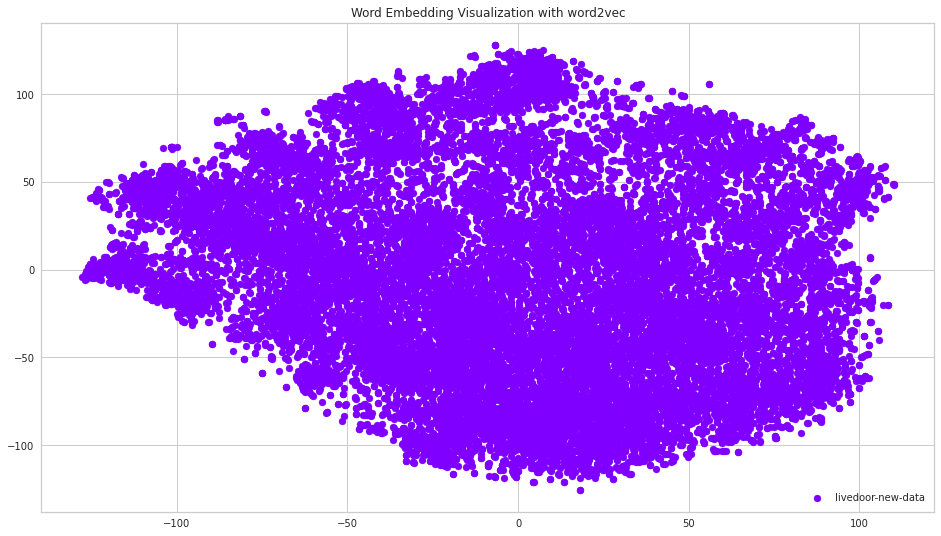

In [38]:
tsne_plot_2d('livedoor-new-data', embeddings_ak_2d, 1)

## Additional Visualization:
We use t-distributed stochastic neighbor embedding, t-SNE to visualize the plot above. 

By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is a popular mwthed to visualize documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot.

Unfortunately, TSNE is very expensive, so typically a simpler decomposition method such as SVD or PCA is applied ahead of time. 

In this additional visualization, I apply TSNEVisualizer - an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default), then performs the t-SNE embedding. 


 * ### Visualize the whole dataset:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


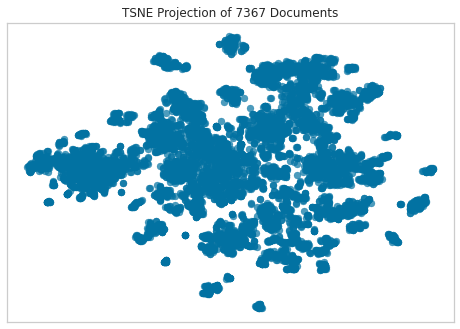

<AxesSubplot:title={'center':'TSNE Projection of 7367 Documents'}>

In [39]:

# Load the data and create document vectors
text = df['clean_five']
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(text)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X)
tsne.show()


* ### Visualize the data by class: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

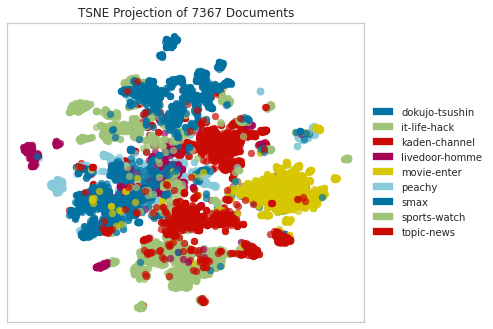

<AxesSubplot:title={'center':'TSNE Projection of 7367 Documents'}>

In [40]:
# Load the data and create document vectors
text = df['clean_five']
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(text)
y = df.label

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

## <a id='4.3'> 4.3. Question (2.2):</a>

埋め込み表現(=ベクトル)を使い、任意の記事を一つピックアップし、それと内容が類似した記事を見 つけてきてください。

In this challenge, we'll use an embedded expression (= vector) to pick up one arbitrary article and see articles with similar contents.

There are different approach to measure the similarity between texts: Euclidean distance, Cosine similarity, 
Similarity with word embeddings (Word2vec similarity, Word movers distance), Nearest-neighbors search, Clustering...

I'll chose to use  the similarity with word embedding using gensim.similarities for an efficient out-of-core sharded index. Because of its is flexible class, this approach is my first choice.

Process: bow -> tfidf -> lsi in gensim

## <a id='4.4'> 4.4 Solution: Query Similarity with Gensin </a>

In [41]:
# turn our tokenized documents into a id <-> term dictionary

dictionary = corpora.Dictionary(corpus)

# filter the dictionary to remove infrequent (no_below) and too frequent (no_above) terminology

dictionary.filter_extremes(no_below=.01, no_above=0.99)

print(dictionary)

Dictionary<51794 unique tokens: ['アスリート', 'ゲット', 'スイマー', 'ネット', 'バタフライ']...>


In [42]:
# create bag of words 
bow_corpus = [dictionary.doc2bow(sent) for sent in corpus]

# create tfidf model 
tfidf = models.TfidfModel(bow_corpus)

# convert bow to tfidf 
tfidf_corpus = tfidf[bow_corpus] 

# view the first transformed sentence
print(tfidf_corpus[0])

[(0, 0.0774309655016183), (1, 0.07478732214172211), (2, 0.12212238186225906), (3, 0.030558593906197466), (4, 0.40049541687640183), (5, 0.06894800902491394), (6, 0.1009430971606559), (7, 0.08226068395521816), (8, 0.12852953840987108), (9, 0.07960215581341276), (10, 0.3193889093781686), (11, 0.028414472623174182), (12, 0.13248439719498697), (13, 0.11759619919751027), (14, 0.14191784641747376), (15, 0.5079037098959154), (16, 0.18740979734464625), (17, 0.0816584433914205), (18, 0.129001701126675), (19, 0.06281643991652636), (20, 0.16371410150592425), (21, 0.0558387724700558), (22, 0.11509005257364155), (23, 0.12391118433516209), (24, 0.12212238186225906), (25, 0.00946539947752376), (26, 0.05274579408420738), (27, 0.02579289992499911), (28, 0.1153451054527247), (29, 0.06935382419782007), (30, 0.1280991917150947), (31, 0.08226068395521816), (32, 0.05481877341232461), (33, 0.12048933315068079), (34, 0.14110833085654784), (35, 0.06874834522136221), (36, 0.22575894917253372), (37, 0.06103944568

In [43]:
# create an lsi model 
# corpus = data to fit model
# id2word = corpus stores words with numeric ids, this dict maps ids back to the original terms
lsi = models.LsiModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=20)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/gensim/models/lsimodel.py:963: DeprecationWarning:

Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.



In [44]:
# convert the tfidf corpus to lsi (e.g. truncatedsvd.transform)
lsi_corpus = lsi[tfidf_corpus]
print(lsi_corpus[0])

[(0, -0.07003150238594927), (1, -0.01776507135967797), (2, -0.0866178357647364), (3, -0.03504621154891395), (4, 0.018440442640850173), (5, -0.11880458077754184), (6, 0.011303980383367166), (7, 0.061692102811688236), (8, -0.030908979339208904), (9, -0.00800031329697436), (10, -0.015568636076756607), (11, 0.0064863144103027804), (12, 0.00595103973526798), (13, -0.001633989605356431), (14, -0.07065768407937462), (15, -0.007416434640678574), (16, 0.026637344575031724), (17, -0.10391783691990447), (18, 0.02421390474268226), (19, -0.031725680870155405)]


In [45]:
from gensim.similarities import Similarity

# transform corpus to LSI space and index it
index = Similarity(
      output_prefix='lsi.mm', # output_prefix - local file to write index
      corpus=lsi_corpus, # corpus - data to fit model
      num_features=lsi.num_terms, # num_features - often the num_terms in the corpus
      shardsize=32768
)

In [46]:
def query(x):
    a= corpus.iloc[x] # locate the query 
    vec_bow = dictionary.doc2bow(a) # convert to bag of words
    tfidf_bow = tfidf[vec_bow] # convert bow to tfidf
    vec_lsi = lsi[tfidf_bow]
    sims = index[vec_lsi]  # perform a similarity query against the corpus
    sims = sorted(enumerate(sims))
    for position, score in sims:
        if score> 0.95: # set the similarity threshold
            similar_text= df['text'].iloc[position]
            print(position, score)
            print(similar_text)

Now, I'll pick up a random row, row 2611 for example and print the most similar queries ( at least 95% similar) with the query 2611.
You can set your own similarity threshold depends on the business problem

In [47]:
query(2611)

10 0.9616035
【2012年先取り映画vol.8】渡辺謙、リーダーシップはあるが嫌な奴に今年のおすすめ新作映画をムービーエンター編集員が選んでご紹介する「2012年先取り映画」。最後の8本目は、ヒーロー妄想のカンタがご紹介。幾多の困難を乗り越えて満身創痍になりながらも、人類初の偉業を成し遂げた「はやぶさ」を、配給会社三社が競って映画化。一番手の20世紀フォックス映画の作品『はやぶさ／HAYABUSA』は既に昨年に公開されているが、それに続く二番手は東映の作品が、2月11日に続く。今回は、この二番手作品を取り上げたいと思う。『はやぶさ 遥かなる帰還』小惑星探査機「はやぶさ」を搭載したロケットが打ち上げられた。それは、小惑星の地表から、岩石サンプルを持ち帰るという極めて高難度な計画であった。さらに想定もしていなかったトラブルが続発。技術者たちは「はやぶさ」の帰還を信じて難題に挑んでいく。（公開予定日：2月11日）ところで「はやぶさ」って何をしたの？「はやぶさ」の偉業に関しては、一般常識レベルになっているが、「実は何がすごいのかわからない。でも、いまさら聞けない」という方もいるのでは？　そこで、まとめてみた。【成果】小惑星イトカワから、物質サンプルを持ち帰った【なぜこのプロジェクトを？】太陽系の起源を知るために小惑星の物質を研究する必要がある。小惑星である理由は、誕生当時の物質がそのまま残っている可能性が高いから。大きな星だと中心部が高温なために物質が変質してしまい、生誕時のものが残っていない。【記録】・電気推進エンジンを世界で初めて3台同時運転・宇宙用リチウムイオン二次電池をバッテリとした世界初の宇宙機・イオンエンジンを搭載した宇宙機として世界で最も太陽から遠方に到達・イオンエンジンと地球スイングバイとの併用に世界で初めて成功・史上最も小さい天体へのランデブーに成功・世界で初めて小惑星（月以外の天体）からの離陸に成功・小惑星表面を史上最も詳しく観測・史上最も小さい天体へ軟着陸、離陸・世界で初めて、月以外の天体からの地球帰還、及びサンプルリターン達成。・光学的手法により、自力で史上最も遠い天体への接近・到達・着陸・離陸・最も長い期間・距離を航行し、地球に帰還した宇宙機（2,592日間、60億km）・最も長い時間、動力飛行をした宇宙機スイングバイ、ランデブーなど専

# <a id='5'> 5. Text Classification: </a>

## <a id='5.1'>5.1. Question (2.3): </a>

埋め込み表現(=ベクトル)を使い、記事のカテゴリを分類するモデルを作ってください。

その性能評価も出してみましょう。


In this talk, I need to apply a model that classifies article categories using embedded expressions (= vectors) and also give the performance evaluation.



## <a id='5.2'>5.2. Solution: Text Classification with Naive Bayes: </a>

Our data contains 7367 observations and 2 feature ( text and label). It's technically a simple data set. I'd use cheat sheet given by sklearn here (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to determine the best model to use for a particular problem. 

It tell us to use NB classifier. The Naive Bayes Classifier, a simplified version of the Bayes Theorem, is used as a classification algorithm to classify data into various classes with accuracy and speed. Naive Bayes Model works particularly well with text classification and spam filtering.

** Pros: 

- Requires small amount of training data to learn the parameters

- Can be trained relatively fast compared to sophisticated models

- Computation time is short.

** Cons: 

- The assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.

- Easy to overfit the model.

In [48]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [49]:
le = LabelEncoder()
le.fit(df.label)
print(le.classes_)

['dokujo-tsushin' 'it-life-hack' 'kaden-channel' 'livedoor-homme'
 'movie-enter' 'peachy' 'smax' 'sports-watch' 'topic-news']


In [50]:
#convert the classes into numeric value
class_in_int = le.transform(df.label)
print(class_in_int)

[7 2 5 ... 1 6 0]


In [51]:
# Split into training and testing data
x = df['clean_five']
y = class_in_int
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)


In [52]:
# Vectorize text reviews to numbers
vec = CountVectorizer()
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

In this step we generate our model fitting our dataset in the MultinomialNB. 

In [53]:
# Model generation and evaluation

MNB = MultinomialNB()
MNB.fit(x_train, y_train)

from sklearn import metrics
predicted = MNB.predict(x_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinomialNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))


MultinomialNB model accuracy is 89.31%
------------------------------------------------
Confusion Matrix:
     0    1    2    3    4    5    6    7    8
0  183    2    1    3   10   16    1    0    2
1    3  193    4    1    2    0   11    0    3
2    2    5  191    3    1    1    5    1    7
3    3    9    2  101    5    8    0    0    0
4    1    0    0    0  215    1    0    0    1
5   19    1    1    8   12  164    3    0    2
6    0    6    1    1    1    2  207    0    0
7    1    0    0    0    0    0    0  221    3
8    4    2    2    0    4    0    1    9  170
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       218
           1       0.89      0.89      0.89       217
           2       0.95      0.88      0.91       216
           3       0.86      0.79      0.82       128
           4       0.86      0.99      0.92       218
           5       0.85    

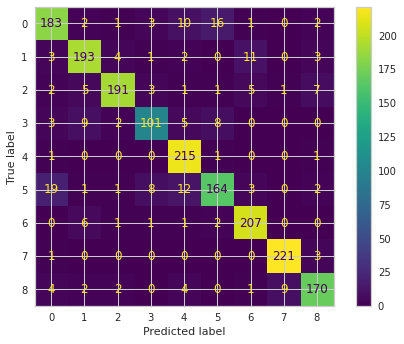

In [54]:
plot_confusion_matrix(MNB,x_test, y_test)

The model accuracy is 89.31% with MultinomialNB model. 

This result is considerably good. Now we will try different approach to see whether we even can improve the accuracy of the model.

## <a id='5.3'>5.3. Question (2.4): </a>

2.3で作成したモデルの精度を上げるためには、どのような課題・改善方法が考えられるでしょうか。

思いつくものを列挙し、その中で特に優先度高く取り組むものについて教えて下さい。

In this section, We will consider the issue/improvement methods to improve the the accuracy of the model we've just created using MultinomialNB. 

- Improve your model my adding bigrams and tri-grams as features.

- Try different Naive Bayes Algorithms: ComplementNB, GaussianNB, BernoulliNB

- Change BOW method: TF-IDF

- Apply non Bayesian algorithms: LogisticRegression, SGDClassifier, LinearSVC




## <a id='5.4'>5.4. Solution: Improve the accuracy of the model: </a>

### a) Trying different n-grams: bigrams

In [ ]:
# Split into training and testing data
x = df['clean_five']
y = class_in_int
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)

# Vectorize text reviews to numbers
vec = CountVectorizer(ngram_range = (2,2))
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

In [ ]:
# Model generation and evaluation

MNB = MultinomialNB()
MNB.fit(x_train, y_train)

from sklearn import metrics
predicted = MNB.predict(x_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinomialNB model with bigrams accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')


### b) Trying different n-grams: trigrams

In [ ]:

# Vectorize text reviews to numbers
vec = CountVectorizer(ngram_range = (3,3))
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

# Model generation and evaluation

MNB = MultinomialNB()
MNB.fit(x_train, y_train)

from sklearn import metrics
predicted = MNB.predict(x_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinomialNB model with trigrams accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')

### c) Try different Naive Bayes Algorithms: ComplementNB


In [55]:
# Split into training and testing data
x = df['clean_five']
y = class_in_int
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)

# Vectorize text reviews to numbers
vec = CountVectorizer()
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

# Model generation and evaluation
from sklearn.naive_bayes import ComplementNB
CNB = ComplementNB()
CNB.fit(x_train, y_train)

from sklearn import metrics
predicted = CNB.predict(x_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')

ComplementNB model accuracy is 87.30%


### e)Try different Naive Bayes Algorithms: BernoulliNB


In [56]:
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(x_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(x_test),y_test)
print('BNB accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')

BNB accuracy = 86.86%


--> The accuracy rate of those model are lower the original model. Trying different Naive Bayes Algorithms couldn't improve the accuracy of the model.

### f) Change BOW method: TF-IDF
Currently we created BOW with CountVectorizer which counts the occurance of the word in the text. 
In order to improve our model let's try to change the way the BOW is created. 

I choose TF-IDF: Term Frequency-Inverse Document Frequency as a new BOW method

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
text_count_2 = tfidf.fit_transform(df['clean_five'])

#splitting the data in test and training
#from sklearn.model_selection() import train_test_split()
x_train, x_test, y_train, y_test = train_test_split(text_count_2,class_in_int,test_size=0.25,random_state=5)

In [61]:

#defining the model
#compilimg the model -> we are going to use already used models GNB, MNB, CNB, BNB
#fitting the model
MNB.fit(x_train, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(x_test), y_test)
print('accuracy_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')

BNB.fit(x_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(x_test), y_test)
print('accuracy_score_bnb = '+str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')

CNB.fit(x_train, y_train)
accuracy_score_cnb = metrics.accuracy_score(CNB.predict(x_test), y_test)
print('accuracy_score_cnb = '+str('{:4.2f}'.format(accuracy_score_cnb*100))+'%')

#GNB.fit(x_train.todense(), y_train)
#accuracy_score_gnb = metrics.accuracy_score(GNB.predict(x_test.todense()), y_test)
#print('accuracy_score_gnb = '+str('{:4.2f}'.format(accuracy_score_gnb*100))+'%')

accuracy_score_mnb = 84.53%
accuracy_score_bnb = 86.81%
accuracy_score_cnb = 86.75%


--> Changing the BOW method to TF-IDF and apply to different NB algorithms don't improve the accuracy of the model

### k) Apply non Bayesian algorithms: LogisticRegression, SGDClassifier, LinearSVC

Even the Tfidf vectorizer i.e creating a different BOW didn't help in imporving the accuracy of the model. 

Rather than naive bayes algorithm we can also opt for stochastic gradient descent classifier or linear support vector classifier. Both of these are known to work well with the text data classification. Let's try to use these:

In [62]:

SGDC = SGDClassifier()
LSVC = LinearSVC()

In [63]:
#on TF-IDF data for LinearSVC model
LSVC.fit(x_train, y_train)
accuracy_score_lsvc = metrics.accuracy_score(LSVC.predict(x_test), y_test)
print('accuracy_score_lsvc_tfidf = '+str('{:4.2f}'.format(accuracy_score_lsvc*100))+'%')

accuracy_score_lsvc_tfidf = 93.81%


In [64]:
#on TF-IDF DATA for SGDC model
SGDC.fit(x_train, y_train)
accuracy_score_sgdc = metrics.accuracy_score(SGDC.predict(x_test), y_test)
print('accuracy_score_sgdc_tfidf = '+str('{:4.2f}'.format(accuracy_score_sgdc*100))+'%')

accuracy_score_sgdc_tfidf = 93.49%


In [65]:
#on CountVectorize data LinearSVC
LSVC.fit(x_train, y_train)
accuracy_score_lsvc_CV = metrics.accuracy_score(LSVC.predict(x_test), y_test)
print('accuracy_score_lsvc_cv = '+str('{:4.2f}'.format(accuracy_score_lsvc_CV*100))+'%')


accuracy_score_lsvc_cv = 93.81%


In [66]:
#on CountVectorize data for SGDC model
SGDC.fit(x_train, y_train)
accuracy_score_sgdc_CV = metrics.accuracy_score(SGDC.predict(x_test), y_test)
print('accuracy_score_sgdc_cv = '+str('{:4.2f}'.format(accuracy_score_sgdc_CV*100))+'%')

accuracy_score_sgdc_cv = 93.76%


--> Applying other text classification algorithms rather than MultinomialNB model can improve the accuracy of the model up to ~ 92.00%

# <a id='6'>6. Extraction of characteristic words: </a>

## <a id='6.1'>6.1. Question (3):</a>


各ニュースカテゴリごとの特徴語句を抽出してください。

In this final task, I have to extract the feature phrases for each news category.

Extract the feature phrases in this context according to my understand is Topic Modelling. 

Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

Here we are going to apply LDA to a set of documents and split them into topics. Let’s get started!

## <a id='6.2'>  6.2. Solution: Topic Modelling with LDA </a>
From now, I will conduct the Topic Modelling for the whole dataset. Extracting the topic modelling can use absolutely the same approach with loops!  The process are computational expensive and time-consuming so I present here only the solution of Topic Modelling for all the data in the sample. 


To keep things simple, I’ll keep all the parameters to default except for inputting the number of topics.\

For this tutorial, I will build a model with 5 topics where each topic is a combination of keywords, 
and each keyword contributes a certain weightage to the topic.


In [67]:
# LDA model training
df['clean_six']= df['clean_five'].apply(lambda x: token.mecab_tokenizer(x))

import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(df['clean_six'])
# Create Corpus
# Term Document Frequency
corpus = [id2word.doc2bow(i) for i in df['clean_six']]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 5), (11, 1), (12, 2), (13, 1), (14, 2), (15, 6), (16, 2), (17, 1), (18, 2), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 2), (29, 1)]


In [68]:
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"年" + 0.005*"アプリ" + 0.004*"日本" + 0.004*"日" + 0.004*"映画" + 0.004*"記事" '
  '+ 0.003*"対応" + 0.003*"月" + 0.003*"円" + 0.003*"android"'),
 (1,
  '0.007*"日" + 0.006*"月" + 0.005*"年" + 0.004*"自分" + 0.004*"日本" + 0.004*"映画" + '
  '0.004*"写真" + 0.003*"記事" + 0.003*"一" + 0.003*"円"'),
 (2,
  '0.007*"年" + 0.006*"日" + 0.006*"月" + 0.005*"映画" + 0.005*"日本" + 0.005*"女性" + '
  '0.004*"記事" + 0.004*"関連" + 0.004*"話題" + 0.003*"円"'),
 (3,
  '0.006*"年" + 0.006*"日" + 0.006*"月" + 0.004*"更新" + 0.004*"発売" + 0.004*"フォン" + '
  '0.004*"女性" + 0.004*"日本" + 0.004*"ソフトウェア" + 0.003*"映画"'),
 (4,
  '0.007*"日" + 0.006*"日本" + 0.006*"ソフト" + 0.006*"月" + 0.005*"バンク" + 0.005*"自分" '
  '+ 0.005*"映画" + 0.004*"年" + 0.003*"話題" + 0.003*"アプリ"')]


In [69]:
#Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/studio-lab

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.014415 -0.008958       1        1  23.290266
0     -0.011321  0.012720       2        1  21.033990
3     -0.014259 -0.011013       3        1  20.500162
4      0.013064  0.008679       4        1  17.891211
1     -0.001900 -0.001429       5        1  17.284370, topic_info=        Term         Freq        Total Category  logprob  loglift
562      バンク  2077.000000  2077.000000  Default  30.0000  30.0000
559      ソフト  2727.000000  2727.000000  Default  29.0000  29.0000
28        更新  2421.000000  2421.000000  Default  28.0000  28.0000
1327  ソフトウェア  1756.000000  1756.000000  Default  27.0000  27.0000
67       アプリ  4384.000000  4384.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
121       機能   630.628209  3756.097789   Topic5  -6.0080  -0.0291
108       対応   600.191905  3630.368441   Topic5  -6.0575  -0.0445
67       アプリ   625.683506  4384.626705   Topic5  -6.0159  -0.1916
27        時間   589.926548  3597.618351   Topic5  -6.0747  -0.0527
222       女性   598.215589  5126.349414   Topic5  -6.0608  -0.3928

[478 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
22779      1  0.045196   akiba
22779      2  0.135589   akiba
22779      3  0.090393   akiba
22779      4  0.135589   akiba
22779      5  0.587553   akiba
...      ...       ...     ...
50041      2  0.069599     ｕｈｆ
50041      3  0.069599     ｕｈｆ
50041      4  0.069599     ｕｈｆ
47948      1  0.056746  ｙａｍａｄａ
47948      4  0.907929  ｙａｍａｄａ

[1290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 5, 2])

# <a id='7'>7. Conclusion: </a>

This Assignment from ABEJA brings me a chance to gain a lot of new knowledge such as extracting text from website to pandas DataFrame,handling Japanese Text, visualing Word Embedding and Extracting Topic Modelling and then apply it to solve all the questions of the assignment.

This was one of the very first times I dealed with Japanese Text data and with the limited of time, My notebook certainly has limitations. I look forward to receiving many comments so that I can improve it better in the future! 



# Reference: 
https://www.scikit-yb.org/en/latest/api/text/tsne.html

https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://github.com/topics/japanese-preprocessing-text

https://www.kaggle.com/code/vochicong/classify-livedoor-news-in-japanese

https://github.com/yoheikikuta/bert-japanese

https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html

https://pythonmachinelearning.pro/text-classification-tutorial-with-naive-bayes/





# THE END

# ありがとうございます！